# 10a: Make plots (extended data)

In this script, we create all plots for the extended data figures.

In [ ]:
import matplotlib.gridspec as gridspec
from matplotlib.cm import get_cmap

In [ ]:
%run common_definitions.py
%run plotting_functions.py

In [ ]:
output_fp = "../output/" + BW_PROJECTNAME

In [ ]:
import os

if not os.path.exists(output_fp+"/plots"):
    os.mkdir(output_fp+"/plots")

if not os.path.exists(output_fp+"/plots/extended_data"):
    os.mkdir(output_fp+"/plots/extended_data")

if not os.path.exists(output_fp+"/tables"):
    os.mkdir(output_fp+"/tables")

if not os.path.exists(output_fp+"/tables/extended_data"):
    os.mkdir(output_fp+"/tables/extended_data")

### Load data

In [ ]:
costs_regional_averages = pd.read_csv(output_fp+"/costs_regional_averages.csv").set_index(
    ["short name", "sector", "scenario", "year", "regional average", "perspective"]
)

In [ ]:
direct_costs_regional_averages = pd.read_csv(output_fp+"/direct_costs_regional_averages.csv").set_index(
    ["short name", "sector", "scenario", "year", "regional average", "perspective"]
)

In [ ]:
indirect_costs_regional_averages = pd.read_csv(output_fp+"/indirect_costs_regional_averages.csv").set_index(
    ["short name", "sector", "scenario", "year", "regional average", "perspective"]
)

In [ ]:
costs_battery_storage = pd.read_csv(output_fp+"/costs_battery_storage.csv").set_index(
    ["ecoinvent name", "scenario", "year", "location", "perspective"]
)

In [ ]:
impacts_regional_averages = pd.read_csv(output_fp+"/impacts_regional_averages.csv").set_index(
    ["short name", "sector", "scenario", "year", "regional average"]
)
impacts_battery_storage = pd.read_csv(output_fp+"/impacts_battery_storage.csv").set_index(
    ["ecoinvent name", "scenario", "year", "location"]
)
mfs_mc_sample_cc = xr.open_dataarray("../data/mfs_monte_carlo_sample_extended_euro{}.nc".format(str(EURO_REF_YEAR)))

In [ ]:
all_perspectives = list(costs_regional_averages.index.unique(level="perspective"))
all_sectors = list(costs_regional_averages.index.unique(level="sector"))
all_techs = list(costs_regional_averages.index.unique(level="short name"))

In [ ]:
plottingnames = pd.read_csv("../mappings/plotting-names.csv").set_index(["short name"])

missing_techs = [tech for tech in all_techs if tech not in plottingnames.index]

plottingnames2 = pd.DataFrame(
    {
        "plotting name (title)": missing_techs,
        "plotting name (tick)": missing_techs,
    },
    index=missing_techs
)

plottingnames = pd.concat((plottingnames, plottingnames2), axis=0)

tech2title = dict(zip(list(plottingnames.index), list(plottingnames["plotting name (title)"])))
tech2tick = dict(zip(list(plottingnames.index), list(plottingnames["plotting name (tick)"])))

In [ ]:
NCVs = pd.read_csv("../data/NCVs_v2.csv")
NCVs["conversion factor"] = np.where(~np.isnan(NCVs["NCV in MJ/product"]), 1/NCVs["NCV in MJ/product"],
                                     np.where(~np.isnan(NCVs["GCV in MJ/product"]), 1/NCVs["GCV in MJ/product"], 1))
conv_factors = dict(zip(list(NCVs["product name"]), list(NCVs["conversion factor"])))

In [ ]:
def get_title_str(s):
    return s.replace("\\n", "\n")

In [ ]:
def get_all_total_costs(impact_df, mfs, contract_dim):
    total_costs = xr.DataArray(
        np.tensordot(impact_df[list(mfs.coords["LCIA method"].values)].to_numpy(),
                    mfs.to_numpy(),
                    axes=([1,], [contract_dim,])),
        coords={
            "tech index": list(range(len(impact_df))),
            "impact category": list(mfs.coords["impact category"].values),
            "sample index": list(range(mfs.shape[1]))
        }
    ).sel({"impact category": list(colors_splitCC.keys())}).sum(dim="impact category")

    return pd.DataFrame(
        total_costs.to_numpy(),
        index=impact_df.index,
        columns=list(range(total_costs.shape[1]))
    )

## In depth comparison to other studies

In [ ]:
eec_literature = pd.read_csv("../data/external_costs_literature_EUR{}.csv".format(EURO_REF_YEAR))
eec_literature = eec_literature[eec_literature["source name"] != "Trinomics"]

In [ ]:
impacts_regional_averages = pd.read_csv(output_fp+"/impacts_regional_averages.csv").set_index(
    ["short name", "sector", "scenario", "year", "regional average"]
)
mfs_mc_sample_cc = xr.open_dataarray("../data/mfs_monte_carlo_sample_extended_euro{}.nc".format(str(EURO_REF_YEAR)))

In [ ]:
scenario = "SSP2-NPi"
year = 2020
sector = "electricity production"
region = "EUR"
sel = impacts_regional_averages.loc[pd.IndexSlice[:, sector, scenario, year, region]]

total_costs = get_all_total_costs(sel, mfs_mc_sample_cc, 2)

In [ ]:
techs_for_comparison = list(eec_literature["short name"].unique())

In [ ]:
df = total_costs.loc[techs_for_comparison].melt(var_name="index", value_name="cost", ignore_index=False)
df["source name"] = "this study"
df["unit"] = "MJ"
df["currency"] = "euro"
df["year"] = 2022

medians = df.reset_index().groupby(["short name"]).agg({"cost": "median"})

plot_data = pd.concat((eec_literature, df.reset_index()), axis=0, ignore_index=True)

plot_data.set_index(["source name", "index", "short name"], inplace=True)

plot_data["normalized cost"] = plot_data["cost"].div(medians["cost"])
plot_data.reset_index(inplace=True)


In [ ]:
plot_data

In [ ]:
fig, axs = plt.subplots(6, 3, sharex=True, sharey=True, figsize=(8, 11))

all_techs = list(plot_data["short name"].unique())
all_titles = [get_title_str(tech2title[tech]) for tech in all_techs]

for i, ax in zip(np.argsort(all_titles), axs.flat):
    tech = all_techs[i]
    sel = plot_data[plot_data["short name"] == tech]
    ax.set_title(get_title_str(tech2title[tech]))

    sns.boxplot(sel, x="source name", y="normalized cost",
            showfliers=False, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.supylabel("Normalized cost")

fig.tight_layout()
fig.savefig(output_fp+"/plots/extended_data/f01_study_comparison.pdf", bbox_inches="tight")

## Perspectives plot for PkBudg500

In [ ]:
tech_selection_rows = {
    "electricity production": [
        "lignite power plant",
        "lignite w CCS (post)",
        "hard coal power plant",
        "hard coal w CCS (post)",
        "natural gas power plant",
        "NGCC w CCS (post)",
        "wood CHP modern",
        "BIGCC w CCS",
        "nuclear, pressure water reactor",
        "PV commercial",
        "wind, offshore",
        "wind, onshore, medium",
        "hydro, reservoir, non-alpine region",
        "geothermal"
    ],
    "district or industrial heat": [
        "lignite CHP",
        "hard coal CHP",
        "oil CHP",
        "natural gas CHP",
        "wood CHP modern",
        "biogas CHP",
        "geothermal heat plant"
    ],
    "residential heating": [
        "lignite briquette stove",
        "wood heater, modern",
        "oil boiler, condensing",
        "natural gas boiler",
        "biomethane boiler",
        "air-water heat pump",
        "brine-water heat pump",
    ],
    "liquids": [
        "heavy fuel oil, refinery",
        "kerosene, refinery",
        "diesel, refinery",
        "diesel, coal FT",
        "diesel, coal FT, w CCS",
        "diesel, gas FT",
        "diesel, gas FT, w CCS",
        "diesel, bio FT",
        "diesel, bio FT, w CCS",
        "diesel, electrolysis FT, VRE",
        "biodiesel, rapeseed oil",
        "bioethanol, corn",
        "bioethanol, corn, CCS",
        "bioethanol, miscanthus",
        "bioethanol, miscanthus, CCS",
        "bioethanol, switchgrass",
        "bioethanol, switchgrass, CCS",
        "bioethanol, forest residue"
    ],
    "hydrogen and gases": [
        "natural gas, onshore",
        "natural gas, offshore",
        "hydrogen, natural gas",
        "hydrogen, natural gas, CCS",
        "hydrogen, hard coal",
        "hydrogen, hard coal, CCS",
        "hydrogen, woody biomass",
        "hydrogen, woody biomass, CCS",
        "hydrogen, PEM electrolysis, VRE"
    ]
}

In [ ]:
widths = [0.5 + 0.5*len(actlist) for actlist in tech_selection_rows.values()]

In [ ]:
non_climate_impacts = [ic for ic in colors_splitCC.keys() if "climate" not in ic]
non_negative_impacts = [ic for ic in colors_splitCC.keys() if "biogenic" not in ic]

In [ ]:
sector2inset = {
    "electricity production": 6,
    "district or industrial heat": 2,
    "residential heating": 0,
    "liquids": 0,
    "hydrogen and gases": 0
} # last n techs that are shown extra in the inset
inset_upperytick = {
    "electricity production": {
        "damage costs": 0.02,
        "prevention costs": 0.003,
        "budget constraint": 0.002,
        "low estimate": 0.002
    },
    "district or industrial heat": {
        "damage costs": 0.003,
        "prevention costs": 0.002,
        "budget constraint": 0.002,
        "low estimate": 0.001
    }
}

In [ ]:
def perspective_plot_by_row_all_w_fractions_w_insets(scenario, year, region, perspectives, sharey=False):
    # nodata = pd.DataFrame(
    #     np.zeros((len(perspectives), plot_data.shape[1])),
    #     index=perspectives,
    #     columns=plot_data.columns
    # )

    fig, axs = plt.subplots(len(perspectives), len(tech_selection_rows), figsize=(15, 10), width_ratios=widths,
                            sharex="col", sharey=sharey)

    line = None

    for i, perspective in enumerate(perspectives):
        for j, sector in enumerate(list(tech_selection_rows.keys())):
            ax = axs[i, j]
            techs_in_data = list(costs_regional_averages.loc[pd.IndexSlice[:, sector, 
                                                               scenario, year, region, :]].index.unique(level="short name"))
            tech_idx = [tech for tech in tech_selection_rows[sector] if tech in techs_in_data]
            plot_data = costs_regional_averages.loc[pd.IndexSlice[:, sector, scenario, 
                                                            year, region, perspective]].loc[tech_idx]
            plot_data = plot_data * 1000
            
            if sector in inset_upperytick.keys():
                comparing_cost_perspectives_subplot(plot_data, ax, inset_techs=sector2inset[sector],
                                                    inset_ytop=1000 * inset_upperytick[sector][perspective])
            else:
                comparing_cost_perspectives_subplot(plot_data, ax)

            if j == 0:
                ax.set_ylabel(perspective2plotname[perspective])

            if i == len(perspectives)-1:
                ax.set_xlabel(sector2plotname[sector])

            ax.set_xticklabels([tech2tick[tech] for tech in tech_idx])

            non_negative_total = plot_data[non_negative_impacts].sum(axis=1)
            non_climate_total = plot_data[non_climate_impacts].sum(axis=1)

            fossil_fraction = plot_data["climate change: fossil"].div(non_negative_total)
            nonclimate_fraction = non_climate_total.div(non_negative_total)

            ax2 = ax.twinx()
            fracline = ax2.plot(fossil_fraction.to_numpy(), "o-", c="C1", zorder=0, 
                                markersize=6, alpha=0.3, linewidth=0.6, label="Fossil fraction")
            # ax2.plot(nonclimate_fraction, linestyle=":", color="Blue")

            bottom, top = ax.get_ylim()

            ax2.set_ylim([bottom/top, 1])
            ticks = [0, 0.5, 1]
            ax2.set_yticks(ticks)
            ax2.tick_params(axis='y', colors="C1")

            # if j < axs.shape[1]-1:
            #     ax2.set_yticks([])

    linestyles = ["-", "dashed", "dotted"]
    handles_size_comparison = []
    for j in range(axs.shape[1]):
        ax_plot = axs[0, j]
        for i in range(1, len(perspectives)):
            perspective = perspectives[i]

            ax_size = axs[i, j]
            top = ax_size.dataLim.bounds[-1]
            cline = ax_plot.axhline(y=top, ls=linestyles[i-1], color="gray", 
                                    label=perspective2plotname[perspective])
            if j == 0:
                handles_size_comparison.append(cline)
            
                
    if line:
        handles = [line[0]] + get_impact_category_handles()
    else:
        handles = get_impact_category_handles()

    if sharey == "col":
        for ax in axs.flat:
            ax.yaxis.set_tick_params(which="both", labelleft=True)

    handles_size_comparison.append(fracline[0])
    fig.legend(loc="upper left", handles=handles, bbox_to_anchor=(0.1, 1.08), fontsize=9, ncols=4)
    fig.legend(loc="upper left", handles=handles_size_comparison, bbox_to_anchor=(0.7, 1.08), fontsize=9)

    fig.supylabel("Cost in EUR{}/GJ".format(EURO_REF_YEAR))
    fig.text(1, 0.5, "Fraction of fossil climate impact", rotation=90, fontsize="large", va="center")

    fig.tight_layout()
    # plt.show()
    if sharey == "col":
        fname = output_fp+"/plots/extended_data/f03_perspectives_by_row_all-sectors_w_fractions_and_insets_sharedy_{}_{}_{}.pdf".format(scenario, year, region)
    else:
        fname = output_fp+"/plots/extended_data/f03_perspectives_by_row_all-sectors_w_fractions_and_insets_{}_{}_{}.pdf".format(scenario, year, region)
    fig.savefig(fname, bbox_inches="tight")

    plt.close()

In [ ]:
scenario = "SSP2-PkBudg500"
year = 2050
region = "overall"

perspectives = [
    "damage costs",
    "prevention costs",
    "budget constraint",
    "low estimate"
]

perspective_plot_by_row_all_w_fractions_w_insets(scenario, year, region, perspectives)

## Regionalized plots for selected technologies

In [ ]:
region_comparison_techs = [
    "wind, onshore, medium",
    "lignite power plant",
    "BIGCC",
    "bioethanol, corn",
    "hydrogen, PEM electrolysis",
    "hydrogen, PEM electrolysis, VRE"
]

region_comparison_sectors = [
    "electricity production",
    "electricity production",
    "electricity production",
    "liquids",
    "hydrogen and gases",
    "hydrogen and gases"  
]

In [ ]:
def region_comparison_selection(scenario, year, perspective):
    fig, axs = plt.subplots(2, 3, sharex=True, figsize=(9, 6))

    for tech, sector, ax in zip(region_comparison_techs, region_comparison_sectors, axs.flat):
        plot_data = costs_regional_averages.loc[pd.IndexSlice[tech, sector, scenario, year, :, perspective]].reset_index()
        plot_data = plot_data[plot_data["regional average"].isin(REMIND_REGIONS)].set_index("regional average")
        
        large_index = REMIND_REGIONS
        zero_pad = pd.DataFrame(
            np.zeros((len(large_index), len(colors_splitCC.keys()))),
            index=large_index,
            columns=colors_splitCC.keys()
        )
        plot_data = zero_pad.add(plot_data) * 1000

        ax.set_title(get_title_str(tech2title[tech]))
        region_subplot(plot_data, ax)
        ax.set_xlabel("")
        ax.set_ylabel("")

    fig.supxlabel("regional average")
    fig.supylabel("Cost ({}) in EUR{}/GJ".format(perspective, EURO_REF_YEAR))

    fig.legend(loc="center left", handles=get_impact_category_handles(palette=colors_splitCC_nobio), 
            bbox_to_anchor=(0.03, -0.1), ncols=3)    

    fig.tight_layout()
    fig.savefig(output_fp+"/plots/extended_data/f02_region_comparison_{}_{}_{}.pdf".format(scenario, year, perspective),
                bbox_inches="tight")

In [ ]:
scenario = "SSP2-NPi"
year = 2030
perspective = "median"

region_comparison_selection(scenario, year, perspective)


In [ ]:
def region_comparison_plot_overview(sector, scenario, year, perspective):
    plot_data = costs_regional_averages.loc[pd.IndexSlice[:, sector, scenario, year, :, perspective]].reset_index()
    plot_data = plot_data[plot_data["regional average"].isin(REMIND_REGIONS)].set_index(["short name", "regional average"])
    
    techlist = list(plot_data.index.unique(level="short name"))
    large_index = pd.MultiIndex.from_product((techlist, REMIND_REGIONS), names=("short name", "regional average"))
    zero_pad = pd.DataFrame(
        np.zeros((len(large_index), len(colors_splitCC.keys()))),
        index=large_index,
        columns=colors_splitCC.keys()
    )
    plot_data = zero_pad.add(plot_data) * 1000

    n = len(techlist) // 3 + 1
    m = 3
    fig, axs = plt.subplots(n, m, sharex=True, figsize=(m*3, n*3))

    for tech, ax in zip(sorted(techlist), axs.flat):
        ax.set_title(get_title_str(tech2title[tech]))
        sel = plot_data.loc[pd.IndexSlice[tech, :]]
        region_subplot(sel, ax)
        ax.set_xlabel("")
        ax.set_ylabel("")

    fig.suptitle(sector)
    fig.supxlabel("regional average")
    fig.supylabel("Cost in EUR{}/GJ".format(EURO_REF_YEAR))
    
    fig.tight_layout()
    fig.savefig(output_fp+"/plots/extended_data/region_comparison_{}_{}_{}_{}.pdf".format(sector, scenario, year, perspective))

In [ ]:
# scenario = "SSP2-NPi"
# year = 2030
# perspective = "median"

# for sector in all_sectors:
#     region_comparison_plot_overview(sector, scenario, year, perspective)


## Trends plots using different perspectives

In [ ]:
trend_selection_techs_stages2 = [
    "diesel, refinery",
    "diesel, electrolysis FT",
    "biodiesel, rapeseed oil",
    "natural gas boiler",
    "air-water heat pump",
    "brine-water heat pump",
    "NGCC",
    "PV commercial",
    "BIGCC",
    "hydrogen, natural gas",
    "hydrogen, woody biomass",
    "hydrogen, PEM electrolysis, VRE"
]

trend_selection_sector_stages2 = [
    "liquids",
    "liquids",
    "liquids",
    "residential heating",
    "residential heating",
    "residential heating",
    "electricity production",
    "electricity production",
    "electricity production",
    "hydrogen and gases",
    "hydrogen and gases",
    "hydrogen and gases"
]

In [ ]:
def cost_trend_plot(region, perspective, fname_suffix="", arrow_positions=[10, 10], arrow_size=10):
    fig, axs = plt.subplots(4, 3, sharex=True,  sharey="row", figsize=(10, 10.5))

    fig.suptitle("Cost trends in region {}, {} costs".format(region, perspective2plotname[perspective]))

    for ax, tech, sector in zip(axs.flat, trend_selection_techs_stages2, trend_selection_sector_stages2):
        sel_direct = direct_costs_regional_averages.loc[pd.IndexSlice[
            tech, sector, :, :, region, perspective
        ]] * 1000
        sel_indirect = indirect_costs_regional_averages.loc[pd.IndexSlice[
            tech, sector, :, :, region, perspective
        ]] * 1000
        cost_trends_subplot_stages(sel_direct, sel_indirect, ax, SCENARIOS, no_bio=True, hatch="..")
        ax.set_title(tech2tick[tech])

    ax = axs[0][0]
    bwidth = 0.3
    spacing = 0.1
    ax.annotate("NPi", xy=(1-(spacing+bwidth)/2, arrow_positions[0]), xytext=(1-(spacing+bwidth)/2, arrow_positions[0]+arrow_size),
                arrowprops=dict(facecolor='black', shrink=0.05), rotation=90, ha="center", va="bottom"
                )
    ax.annotate("1.5°C", xy=(1+(spacing+bwidth)/2, arrow_positions[1]), xytext=(1+(spacing+bwidth)/2, arrow_positions[0]+arrow_size),
                arrowprops=dict(facecolor='black', shrink=0.05), rotation=90, ha="center", va="bottom"
                )

    fig.legend(loc="center left", handles=get_impact_category_handles(palette=colors_splitCC_nobio), 
            bbox_to_anchor=(0.03, -0.05), ncols=3)
    fig.legend(loc="center left", handles=[mpatches.Patch(facecolor=("white", 0.0), edgecolor="C1", label="indirect costs", hatch="..")],
            bbox_to_anchor=(0.8, -0.01))

    fig.supxlabel("Year")
    fig.supylabel("Cost in EUR{}/GJ".format(EURO_REF_YEAR))

    fig.tight_layout()
    fig.savefig(output_fp+"/plots/extended_data/{}_trends_stages2_{}_{}.pdf".format(fname_suffix, region, perspective), bbox_inches="tight")

In [ ]:
region = "EUR"

arrow_positions = [[20, 20], [30, 30]]
arrow_size = 40

for i, perspective in enumerate([
    "damage costs",
    "prevention costs"]):
    suffix = "f0{}_".format(4+i)
    cost_trend_plot(region, perspective, fname_suffix=suffix,
                    arrow_positions=arrow_positions[i], arrow_size=arrow_size)

## Plots with costs of battery storage

### Load data and calculate installation fraction

In [16]:
shares_battery_types = pd.read_csv("../data/stationary_battery_scenarios.csv")

name2batscen = {
    "market for battery capacity, stationary (CONT scenario)": "CONT",
    "market for battery capacity, stationary (TC scenario)": "TC",
}

lifetimes_xr =  xr.DataArray(
    [25, 30],
    coords={
        "short name": ["wind, onshore, medium", "PV commercial"]
    }
)

VRE_techs = ["PV commercial", "wind, onshore, medium"]

samples = 30
minval = 4
maxval = 6
energy2power = xr.DataArray(
    np.linspace(minval, maxval, samples),
    coords={
        "sample index": np.arange(samples)
    }
)

capfacs = pd.read_csv(output_fp+"/capacity_factors_VRE.csv").replace({"SSP2-NPi": "NPi", "SSP2-PkBudg650": "1.5°C"})
capfacs_xr = capfacs.set_index(["short name", "region", "scenario", "year"])["capacity factor"].to_xarray()
capfacs_xr = capfacs_xr.sel({"region": REMIND_REGIONS})

installation_fraction_xr = 1 / (capfacs_xr * 8760 * lifetimes_xr)

vre_shares = pd.read_csv(output_fp+"/vre_input_shares.csv").replace({"SSP2-NPi": "NPi", "SSP2-PkBudg500": "1.5°C"})
vre_shares_xr = vre_shares.set_index(["short name", "region", "scenario", "year"])["share"].to_xarray()

pem_efficiencies = pd.read_csv(output_fp+"/PEM_efficiencies.csv").replace({"SSP2-NPi": "NPi", "SSP2-PkBudg650": "1.5°C"})
pem_efficiencies_xr = pem_efficiencies.set_index(["region", "scenario", "year"])["PEM efficiency"].to_xarray() / 100

In [17]:
def select_battery_data(perspective):
    # electricity production costs
    sel = costs_regional_averages.loc[pd.IndexSlice[VRE_techs, "electricity production", :, :, :, perspective]]
    totals = sel[list(colors_splitCC.keys())].sum(axis=1).droplevel([1, 5]).reset_index().rename(columns={"regional average": "region", 0: "total cost"})
    totals = totals[totals["region"].isin(REMIND_REGIONS)]
    totals = totals.replace({"SSP2-NPi": "NPi", "SSP2-PkBudg500": "1.5°C"})
    totals_xr = totals.set_index(["short name", "scenario", "year", "region"])["total cost"].to_xarray()

    # battery storage costs
    sel2 = costs_battery_storage.loc[pd.IndexSlice[:, :, :, "GLO", perspective]]
    totals_battery = sel2[list(colors_splitCC.keys())].sum(axis=1).reset_index().rename(columns={0: "total cost"})
    totals_battery = totals_battery.replace({"SSP2-NPi": "NPi", "SSP2-PkBudg650": "1.5°C"})
    totals_battery_xr = totals_battery.set_index(["ecoinvent name", "scenario", "year"])["total cost"].to_xarray()

    # hydrogen production costs
    sel3 = costs_regional_averages.loc[pd.IndexSlice["hydrogen, PEM electrolysis, VRE", "hydrogen and gases", :, :, :, perspective]]
    totals_h2 = sel3[list(colors_splitCC.keys())].sum(axis=1).reset_index().rename(columns={"regional average": "region", 0: "total cost"})
    totals_h2 = totals_h2[totals_h2["region"].isin(REMIND_REGIONS)]
    totals_h2 = totals_h2.replace({"SSP2-NPi": "NPi", "SSP2-PkBudg500": "1.5°C"})
    totals_h2_xr = totals_h2.set_index(["scenario", "year", "region"])["total cost"].to_xarray()

    return totals_xr, totals_battery_xr, totals_h2_xr

def get_battery_data_all_perspectives():
    perspectives = ["damage costs", "prevention costs", "budget constraint", "low estimate", "median"]
    # electricity production costs
    sel = costs_regional_averages.loc[pd.IndexSlice[VRE_techs, "electricity production", :, :, :, perspectives]]
    totals = sel[list(colors_splitCC.keys())].sum(axis=1).droplevel([1]).reset_index().rename(columns={"regional average": "region", 0: "total cost"})
    totals = totals[totals["region"].isin(REMIND_REGIONS)]
    totals = totals.replace({"SSP2-NPi": "NPi", "SSP2-PkBudg500": "1.5°C"})
    totals_xr = totals.set_index(["short name", "scenario", "year", "region", "perspective"])["total cost"].to_xarray()

    # battery storage costs
    sel2 = costs_battery_storage.loc[pd.IndexSlice[:, :, :, "GLO", perspectives]]
    totals_battery = sel2[list(colors_splitCC.keys())].sum(axis=1).reset_index().rename(columns={0: "total cost"})
    totals_battery = totals_battery.replace({"SSP2-NPi": "NPi", "SSP2-PkBudg650": "1.5°C"})
    totals_battery_xr = totals_battery.set_index(["ecoinvent name", "scenario", "year", "perspective"])["total cost"].to_xarray()

    # hydrogen production costs
    sel3 = costs_regional_averages.loc[pd.IndexSlice["hydrogen, PEM electrolysis, VRE", "hydrogen and gases", :, :, :, perspectives]]
    totals_h2 = sel3[list(colors_splitCC.keys())].sum(axis=1).reset_index().rename(columns={"regional average": "region", 0: "total cost"})
    totals_h2 = totals_h2[totals_h2["region"].isin(REMIND_REGIONS)]
    totals_h2 = totals_h2.replace({"SSP2-NPi": "NPi", "SSP2-PkBudg500": "1.5°C"})
    totals_h2_xr = totals_h2.set_index(["scenario", "year", "region", "perspective"])["total cost"].to_xarray()

    return totals_xr, totals_battery_xr, totals_h2_xr

def get_battery_data_mc():
    # electricity production costs
    sel = impacts_regional_averages.loc[pd.IndexSlice[VRE_techs, "electricity production", :, :, :]]
    total_costs_elec = get_all_total_costs(sel, mfs_mc_sample_cc, 2).melt(ignore_index=False, var_name="MC index", value_name="total cost").droplevel(1)
    total_costs_elec = total_costs_elec.reset_index().rename(columns={"regional average": "region"})
    total_costs_elec = total_costs_elec[total_costs_elec["region"].isin(REMIND_REGIONS)]
    total_costs_elec = total_costs_elec.replace({"SSP2-NPi": "NPi", "SSP2-PkBudg500": "1.5°C"})
    totals_xr = total_costs_elec.set_index(["short name", "scenario", "year", "region", "MC index"])["total cost"].to_xarray()

    sel2 = impacts_battery_storage.loc[pd.IndexSlice[:, :, :, "GLO"]]
    total_costs_battery = get_all_total_costs(sel2, mfs_mc_sample_cc, 2).melt(ignore_index=False, var_name="MC index", value_name="total cost")
    total_costs_battery = total_costs_battery.reset_index()
    total_costs_battery = total_costs_battery.replace({"SSP2-NPi": "NPi", "SSP2-PkBudg650": "1.5°C"})
    totals_battery_xr = total_costs_battery.set_index(["ecoinvent name", "scenario", "year", "MC index"])["total cost"].to_xarray()

    return totals_xr, totals_battery_xr

In [18]:
def battery_storage_plot_methods():    
    # plotting
    fig, axs = plt.subplots(1, 2, sharex=False, sharey="row", figsize=(8, 5))

    # battery scenario shares
    for j, bscen in enumerate(["CONT", "TC"]):
        ax = axs[j]
        ax.set_title("{} scenario".format(bscen))
        chemistry_shares = shares_battery_types[shares_battery_types["scenario"] == bscen]
        pdata = chemistry_shares.pivot(index="year", columns="chemistry", values="value")
        if (j == 0):
            pdata.plot.area(stacked=True, ax=ax).legend(loc="lower right")
        else:
            pdata.plot.area(stacked=True, ax=ax, legend=False)
        ax.set_xlabel("")

    fig.supylabel("market share")
    fig.supxlabel("year")

    fig.tight_layout()
    fig.savefig(output_fp+"/plots/main/00b_battery_scenarios.pdf", bbox_inches="tight")


In [ ]:
cap_variant = "new_cap"
perspective = "median"

cap_ratios = pd.read_csv(output_fp + f"/capacity_ratios_battery_storage_{cap_variant}.csv").set_index(["short name", "scenario", "region", "year"])
cap_ratios = cap_ratios.loc[pd.IndexSlice[:, :, :, :]].reset_index()
cap_ratios = cap_ratios.replace({"SSP2-NPi": "NPi", "SSP2-PkBudg650": "1.5°C"})
cap_ratios_xr = cap_ratios.set_index(["short name", "scenario", "region", "year"])["capacity ratio"].to_xarray()
cap_ratios_xr = cap_ratios_xr.sel({"region": REMIND_REGIONS})

# select data
totals_xr, totals_battery_xr, totals_h2_xr = select_battery_data(perspective)

# calculations
f = cap_ratios_xr * (energy2power * installation_fraction_xr)
battery_costs_per_kWh = totals_battery_xr * f
power_costs_per_kWh = totals_xr * 3.6
battery_costs_relative = 100 * (battery_costs_per_kWh / power_costs_per_kWh)
h2_battery_costs_per_MJ = (battery_costs_per_kWh * vre_shares_xr).sum(dim="short name") / (3.6 * pem_efficiencies_xr)
batttery_costs_relative_h2 = 100 * (h2_battery_costs_per_MJ / totals_h2_xr)

In [ ]:
pdata = installation_fraction_xr.to_dataframe(name="installation fraction").reset_index()
# pdata["battery scenario"] = pdata["ecoinvent name"].map(name2batscen)

sns.lineplot(pdata, x="year", y="installation fraction", hue="short name", style="scenario")

In [ ]:
pdata = cap_ratios_xr.to_dataframe(name="capacity ratio").reset_index()
# pdata["battery scenario"] = pdata["ecoinvent name"].map(name2batscen)

sns.lineplot(pdata, x="year", y="capacity ratio", hue="short name", style="scenario")

In [ ]:
pdata = battery_costs_per_kWh.to_dataframe(name="cost mark-up").reset_index()
pdata["battery scenario"] = pdata["ecoinvent name"].map(name2batscen)

sns.lineplot(pdata, x="year", y="cost mark-up", hue="short name", style="scenario")

In [ ]:
def battery_storage_plot(perspective, cap_variant, mc=False):
    # load more data
    cap_ratios = pd.read_csv(output_fp + f"/capacity_ratios_battery_storage_{cap_variant}.csv").set_index(["short name", "scenario", "region", "year"])
    cap_ratios = cap_ratios.loc[pd.IndexSlice[:, :, :, :]].reset_index()
    cap_ratios = cap_ratios.replace({"SSP2-NPi": "NPi", "SSP2-PkBudg650": "1.5°C"})
    cap_ratios_xr = cap_ratios.set_index(["short name", "scenario", "region", "year"])["capacity ratio"].to_xarray()
    cap_ratios_xr = cap_ratios_xr.sel({"region": REMIND_REGIONS})

    # select data
    totals_xr, totals_battery_xr, totals_h2_xr = select_battery_data(perspective)

    # calculations
    f = cap_ratios_xr * (energy2power * installation_fraction_xr)
    battery_costs_per_kWh = totals_battery_xr * f
    power_costs_per_kWh = totals_xr * 3.6
    battery_costs_relative = 100 * (battery_costs_per_kWh / power_costs_per_kWh)
    h2_battery_costs_per_MJ = (battery_costs_per_kWh * vre_shares_xr).sum(dim="short name") / (3.6 * pem_efficiencies_xr)
    batttery_costs_relative_h2 = 100 * (h2_battery_costs_per_MJ / totals_h2_xr)

    
    # plotting
    fig, axs = plt.subplots(2, 3, sharex=False, sharey="row", figsize=(12, 9))

    # cost trends
    for j, bscen in enumerate(["CONT", "TC"]):
        ax = axs[0][j]
        ax.set_title("{} scenario".format(bscen))
        tech = "market for battery capacity, stationary ({} scenario)".format(bscen)
        sel = costs_battery_storage.loc[pd.IndexSlice[tech, :, :, "GLO", perspective]]
        if j == 0:
            cost_trends_subplot(sel, ax, SCENARIOS_BATTERIES, annotate_scenarios=True,
                                annotation_names=["NPi", "1.5°c"],
                                arrow_positions = [72, 70], arrow_size=10)
            ax.set_ylabel("Cost in EUR2022 / kWh")
        else:
            cost_trends_subplot(sel, ax, SCENARIOS_BATTERIES)

    ax = axs[0][2]
    ax.legend(loc="center left", handles=get_impact_category_handles(palette=colors_splitCC_nobio), 
            bbox_to_anchor=(0, 0.5), ncols=1)
    ax.axis("off")
    

    # fig.delaxes(axs[0][2])

    # cost increases
    ci = ('ci', 95)
    if mc:
        # recalculate using MC samples
        totals_xr, totals_battery_xr = get_battery_data_mc()
        battery_costs_per_kWh = totals_battery_xr * f
        power_costs_per_kWh = totals_xr * 3.6
        battery_costs_relative = 100 * (battery_costs_per_kWh / power_costs_per_kWh)
        ci = 'sd'
    for j, tech in enumerate(VRE_techs):
        ax = axs[1][j]
        ax.set_title(plottingnames.loc[tech]["plotting name (title)"])
        pdata = battery_costs_relative.sel({"short name": tech}).to_dataframe(name="relative cost").reset_index()
        pdata["battery scenario"] = pdata["ecoinvent name"].map(name2batscen)
        sns.lineplot(pdata, x="year", y="relative cost", hue="scenario", style="battery scenario", ax=ax,
                     estimator="median", errorbar=ci)
        ax.set_xlabel("")
        if j == 0:
            ax.set_ylabel("relative cost increase [%]")
    
    ax = axs[1][2]
    ax.set_title("H2, PEM, VRE inputs")
    pdata = batttery_costs_relative_h2.to_dataframe(name="relative cost").reset_index()
    pdata["battery scenario"] = pdata["ecoinvent name"].map(name2batscen)
    sns.lineplot(pdata, x="year", y="relative cost", hue="scenario", style="battery scenario", ax=ax,
                 estimator="median", errorbar=ci)
    ax.set_xlabel("")

    fig.supxlabel("year")

    fig.tight_layout()
    if mc:
        fig.savefig(output_fp+"/plots/main/04_battery_costs_{}_{}_mc.pdf".format(perspective, cap_variant), bbox_inches="tight")
    else:
        fig.savefig(output_fp+"/plots/main/04_battery_costs_{}_{}.pdf".format(perspective, cap_variant), bbox_inches="tight")


In [ ]:
battery_storage_plot_methods()

In [ ]:
battery_storage_plot("median", "new_cap")

In [19]:
def battery_storage_plot_compare_perspectives(cap_variant):
    # load more data
    cap_ratios = pd.read_csv(output_fp + f"/capacity_ratios_battery_storage_{cap_variant}.csv").set_index(["short name", "scenario", "region", "year"])
    cap_ratios = cap_ratios.loc[pd.IndexSlice[:, :, :, :]].reset_index()
    cap_ratios = cap_ratios.replace({"SSP2-NPi": "NPi", "SSP2-PkBudg650": "1.5°C"})
    cap_ratios_xr = cap_ratios.set_index(["short name", "scenario", "region", "year"])["capacity ratio"].to_xarray()
    cap_ratios_xr = cap_ratios_xr.sel({"region": REMIND_REGIONS})

    # select data
    totals_xr, totals_battery_xr, totals_h2_xr = get_battery_data_all_perspectives()

    # calculations
    f = cap_ratios_xr * (energy2power * installation_fraction_xr)
    battery_costs_per_kWh = totals_battery_xr * f
    power_costs_per_kWh = totals_xr * 3.6
    battery_costs_relative = 100 * (battery_costs_per_kWh / power_costs_per_kWh)
    h2_battery_costs_per_MJ = (battery_costs_per_kWh * vre_shares_xr).sum(dim="short name") / (3.6 * pem_efficiencies_xr)
    batttery_costs_relative_h2 = 100 * (h2_battery_costs_per_MJ / totals_h2_xr)

    
    # plotting
    fig, axs = plt.subplots(1, 3, sharex=False, sharey="row", figsize=(12, 6))

    # cost increases
    ci = ('ci', 95)
    for j, tech in enumerate(VRE_techs):
        ax = axs[j]
        ax.set_title(plottingnames.loc[tech]["plotting name (title)"])
        pdata = battery_costs_relative.sel({"short name": tech}).to_dataframe(name="relative cost").reset_index()
        pdata["battery scenario"] = pdata["ecoinvent name"].map(name2batscen)
        sns.lineplot(pdata, x="year", y="relative cost", hue="perspective", style="scenario", ax=ax,
                     estimator="median", errorbar=ci)
        ax.set_xlabel("")
        if j == 0:
            ax.set_ylabel("relative cost increase [%]")
    
    ax = axs[2]
    ax.set_title("H2, PEM, VRE inputs")
    pdata = batttery_costs_relative_h2.to_dataframe(name="relative cost").reset_index()
    pdata["battery scenario"] = pdata["ecoinvent name"].map(name2batscen)
    sns.lineplot(pdata, x="year", y="relative cost", hue="perspective", style="scenario", ax=ax,
                 estimator="median", errorbar=ci)
    ax.set_xlabel("")

    fig.supxlabel("year")

    fig.tight_layout()
    fig.savefig(output_fp+"/plots/extended_data/f06_battery_costs_perspectives_{}.pdf".format(cap_variant), bbox_inches="tight")


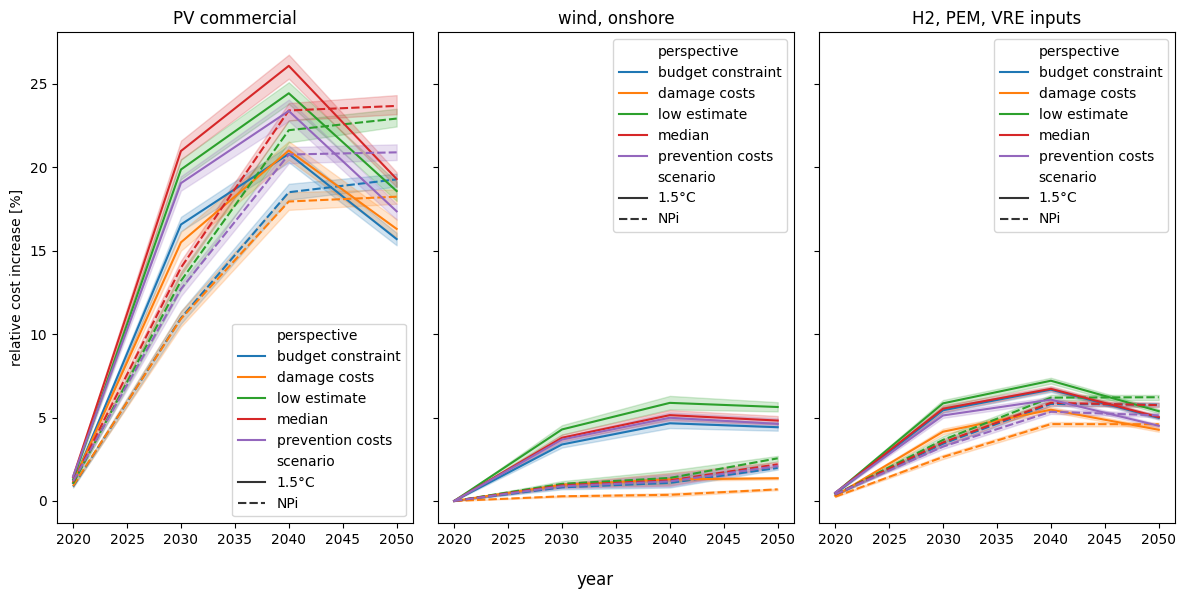

In [20]:
battery_storage_plot_compare_perspectives("new_cap")

## Compile extended data tables

### monetization factors

In [ ]:
df = pd.read_csv("../data/mfs_all_factors.csv").dropna(subset="LCIA method")

In [ ]:
exclude_list = ["Environmental prices, 2023, Netherlands"]

df = df[~df["source name"].isin(exclude_list)]
df.to_csv(output_fp+"/tables/extended_data/T3_monetization_factors.csv", index=False)

### production costs

In [ ]:
df = pd.read_csv("../data/production_costs_euro_{}.csv".format(EURO_REF_YEAR))
df.to_csv(output_fp+"/tables/extended_data/T4_production_costs.csv", index=False)

### Combustion emission factors

In [ ]:
liquids_base = pd.read_csv("../data/liquids_combustion_efs_base.csv")

liquids_base[liquids_base["unit"] != "kilogram"]

In [ ]:
gases_base = pd.read_csv("../data/hydrogen_and_gases_combustion_efs.csv")

gases_base[gases_base["unit"] != "kilogram"]

In [ ]:
efs_liquids = pd.read_csv("../data/liquids_combustion_all_efs.csv")
efs_liquids

In [ ]:
efs_gases = pd.read_csv("../data/hydrogen_and_gases_combustion_all_efs.csv")
efs_gases

In [ ]:
efs = pd.concat((efs_liquids, efs_gases))

units = []
for i, row in efs.iterrows():
    if row["name"] == "Water" and row["categories"].startswith("air"):
        units.append("cubic meter")
    else:
        units.append("kilogram")

efs["unit"] = units
efs["fuel unit"] = "MJ"

efs.set_index("ecoinvent name").sort_index()[["name", "categories", "unit", "fuel unit", "amount"]].to_csv(output_fp+"/tables/extended_data/T2_combustion_emission_factors.csv")

### Mapping file

In [ ]:
df = pd.read_csv("../mappings/technology_selection_energy_provision_v4.csv")

df = df[df["sector"] != "solids"]

df.set_index(["sector", "short name"]).sort_index()[["ecoinvent name", "reference product"]].to_csv(output_fp+"/tables/extended_data/T1_technology_mapping.csv")